# Open Exercise

Select from a (subset of a) dataset generated through [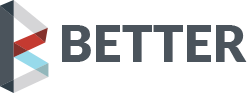](https://www.ec-better.eu/) and perform your own analysis, applying some of the techniques discussed before, or other techniques from your own choice.

* Amazon: CCD Products: Backscatter pre (band 0), post (band 1) and coherence (band 2) for fires detection and characterisation.

    Typical questions to answer:

    * [ ] When did the fire took place?

    * [ ] What are the areas affected and when?

    * [ ] What is the extension of the bunred area? And its evolution?

    * [ ] Can we validate it with external data sources? Can we correlate it with other indicators?

* CharPiya: Backscatter per date.

    Typical questions to answer:

    * [ ] When did the construction of the camp took place? Do you identify different phases in the construction?

    * [ ] What is the extension of the camp?

    * [ ] Was there any flooding event? When? Did it affect the camp?

    * [ ] Can you validate or reference certain events with ancillary data?


In [9]:
!/opt/anaconda/envs/env_better/bin/pip3 install folium shapely rasterio bs4 tqdm geojson sklearn

     |████████████████████████████████| 6.8 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 43.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=206bd0867b9941854d41dd90b0874a80fe96dbbfcecb4fc5b891dd49d4e4a1ba
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [10]:
import rasterio
import rasterio.mask
import requests
import fiona
import json
import geojson
from shapely.geometry import shape
from tqdm import tqdm

In [11]:
full_island = {"type":"Feature", "properties":{}, "geometry":{"type":"Polygon", "coordinates":[[[91.240997090935, 22.411882288286], [91.247863546014, 22.258073694536], [91.452483907342, 22.263566858599], [91.444244161248, 22.42012203438], [91.240997090935, 22.411882288286]]]}, "crs":{"type":"name", "properties":{"name":"urn:ogc:def:crs:OGC:1.3:CRS84"}}}
g1 = geojson.loads(json.dumps(full_island))
g1

{"crs": {"properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}, "type": "name"}, "geometry": {"coordinates": [[[91.240997, 22.411882], [91.247864, 22.258074], [91.452484, 22.263567], [91.444244, 22.420122], [91.240997, 22.411882]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}

In [12]:
from bs4 import BeautifulSoup
import requests


url_charpiya = 'https://store.terradue.com/nextgeoss-change-detection-s1/charpiya/'
url_amazon = 'https://store.terradue.com/nextgeoss-change-detection-s1/s1Burned/'
center_charpiya = [22.38, 91.4]

url = url_charpiya 
center = center_charpiya 

ext = 'tif'

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

vector_fn = 'data/InsideCharpiya.shp'

#with fiona.open(vector_fn, 'r') as shapefile:
#    shapes = [feature['geometry'] for feature in shapefile]

shapes = g1['geometry']

masked_images = list()
dates = list()

with tqdm(total=19) as pbar:
    for file in listFD(url, ext):
        dates.append(file)
        with rasterio.open(file) as src:
            masked_data, masked_transform = rasterio.mask.mask(src, [shapes], crop=True) 
            masked_meta = src.meta
            bbox = shape(shapes).bounds
            img = masked_data[0]
            masked_images.append(img)
            pbar.update(1)
            


100%|██████████| 19/19 [01:16<00:00,  4.02s/it]


/opt/anaconda/envs/env_better/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


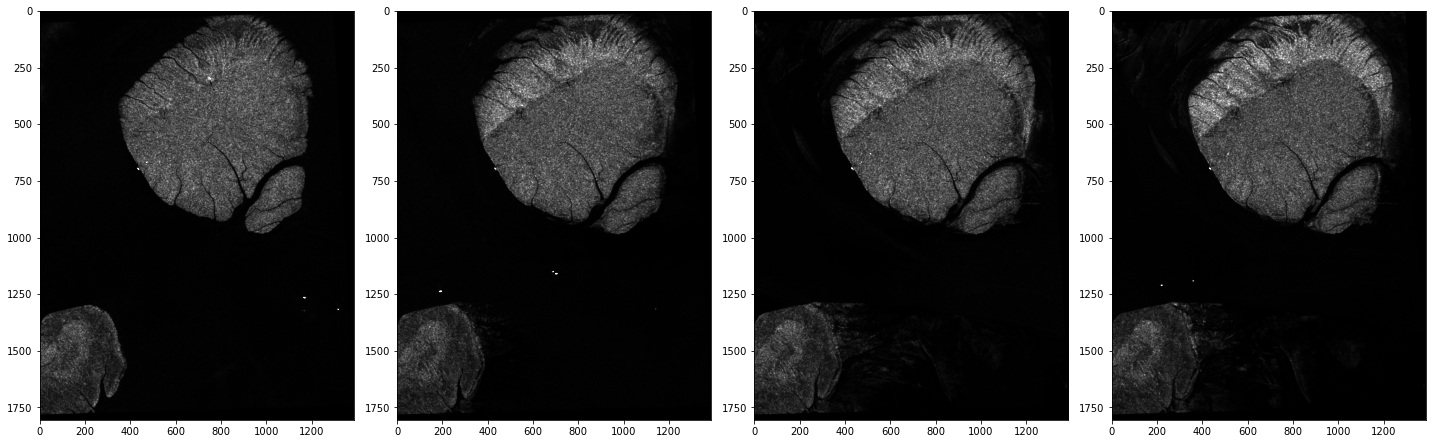

In [13]:
import numpy as np
from helpers import *

shape = (1805, 1386)

preview = np.dstack(img[0:shape[0],0:shape[1]] for img in masked_images[0:4])
plot_bands_row(preview, 0, 0.5)

preview = np.dstack(img[0:shape[0],0:shape[1]] for img in masked_images[4:8])
plot_bands_row(preview, 0, 0.5)

preview = np.dstack(img[0:shape[0],0:shape[1]] for img in masked_images[8:12])
plot_bands_row(preview, 0, 0.5)

preview = np.dstack(img[0:shape[0],0:shape[1]] for img in masked_images[12:16])
plot_bands_row(preview, 0, 0.5)

/opt/anaconda/envs/env_better/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


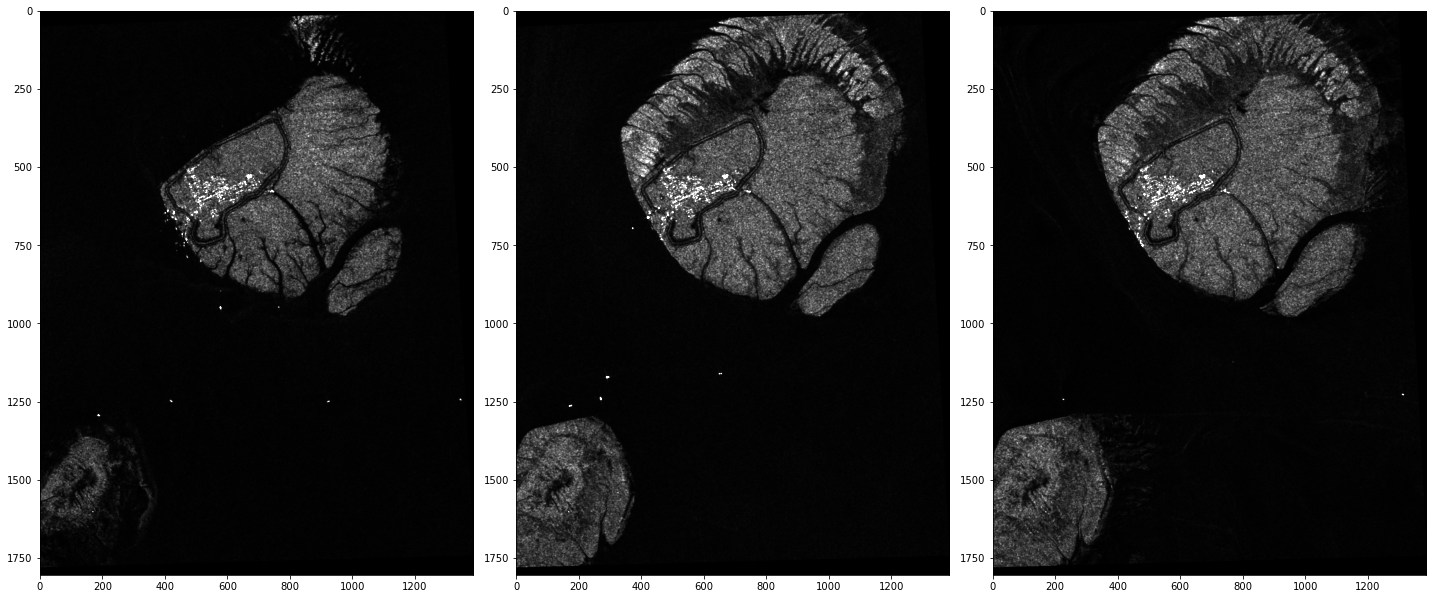

In [14]:
preview = np.dstack(img[0:shape[0],0:shape[1]] for img in masked_images[16:19])
plot_bands_row(preview, 0, 0.5)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
fig.suptitle('Histograms')

for i,img in enumerate(masked_images[16:19]):
    ax[i].hist(img[0:shape[0],0:shape[1]], range=(0,0.5)) 


### The histogram shows different modes, can we extract water as it is covering very much of the scene and we know it has low backscatter?

Also it would be interesting to apply a clustering algorithm and identify those modes automatically

In [ ]:
import numpy.ma as ma
from helpers import *

water_mask = [ma.masked_where(img < 0.05, img).mask for img in masked_images]

plot_bands_row(water_mask[16],0,1)


In [ ]:
rows = 4
cols = 5
axes=[]
fig=plt.figure(figsize=(30,45))

for a in range(rows*cols-1):
    b = water_mask[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Water mask"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)

#fig.tight_layout()    
plt.show()


### Simple quick assessment of the flooding event and when it happened in time

In [ ]:
water_pixels = [np.sum(pixels == True) for pixels in water_mask]


fig = plt.figure(figsize=(15,15))
ax = plt.axes()

labels = [name.rsplit('/', 1)[-1][24:32] for name in dates]

ax.plot(range(0,19), water_pixels);
plt.xticks(range(0,19), labels, rotation=90)

In [ ]:
import fiona
import shapely
import folium
from rasterio.features import shapes as shapebuilder

m = folium.Map([22.38, 91.4], zoom_start=14)
vector_fn = 'data/InsideCharpiya.shp'

with fiona.open(vector_fn, 'r') as shapefile:
    folium.GeoJson(shapefile[0], name='Camp').add_to(m)
    camp = shapefile[0]
    shapes = [feature['geometry'] for feature in shapefile]
    
image = water_mask[16].astype(np.uint8)
mask=None

results = (
    {'type': 'Feature', 'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v)  in enumerate(
            shapebuilder(image, mask=mask, transform= masked_transform))
        )

geoms = list(results)

lambdayield = lambda: [(yield shapely.geometry.shape(x['geometry'])) for x in geoms[0:]]


multip = shapely.geometry.multipolygon.MultiPolygon(list(lambdayield()))

In [ ]:
m = folium.Map([22.38, 91.4], zoom_start=14)

folium.GeoJson(multip[-1], name='Water mask').add_to(m)
folium.GeoJson(camp, name='Camp', style_function=lambda x: {'fillCollor':'#ff0000', 'color': '#ff00ff'}).add_to(m)
folium.LayerControl().add_to(m)
m